In [1]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

data_root = "./data"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

train_set = datasets.CIFAR10(
    root = data_root,
    train = True,
    download = True,
    transform = transform
)

test_set = datasets.CIFAR10(
    root = data_root,
    train = False,
    download = True,
    transform = transform
)

In [2]:
from torch.utils.data import DataLoader

batch_size = 100

train_loader = DataLoader(
    train_set, 
    batch_size = batch_size,
    shuffle = True
)

test_loader = DataLoader(
    test_set,  
    batch_size = batch_size,
    shuffle = False
)

In [3]:
import torch
import torch.nn as nn

class CNN_v2(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1))
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1))
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.l1 = nn.Linear(4*4*128, 128)
        self.l2 = nn.Linear(128, num_classes)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool,
            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.maxpool,
            self.conv5,
            self.relu,
            self.conv6,
            self.relu,
            self.maxpool,
            )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

In [4]:
from tqdm.notebook import tqdm

def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):
    base_epochs = len(history)

    for epoch in range(base_epochs, num_epochs+base_epochs):
        n_train_acc, n_val_acc = 0, 0
        train_loss, val_loss = 0, 0
        n_train, n_test = 0, 0

        net.train()

        for inputs, labels in tqdm(train_loader):
            train_batch_size = len(labels)
            n_train += train_batch_size

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = net(inputs)

            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            predicted = torch.max(outputs, 1)[1]

            train_loss += loss.item() * train_batch_size
            n_train_acc += (predicted == labels).sum().item()

        net.eval()

        for inputs_test, labels_test in test_loader:
            test_batch_size = len(labels_test)
            n_test += test_batch_size

            inputs_test = inputs_test.to(device)
            labels_test = labels_test.to(device)

            outputs_test = net(inputs_test)

            loss_test = criterion(outputs_test, labels_test)

            predicted_test = torch.max(outputs_test, 1)[1]

            val_loss +=  loss_test.item() * test_batch_size
            n_val_acc +=  (predicted_test == labels_test).sum().item()

        train_acc = n_train_acc / n_train
        val_acc = n_val_acc / n_test

        avg_train_loss = train_loss / n_train
        avg_val_loss = val_loss / n_test

        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {val_acc:.5f}')

        item = np.array([epoch+1, avg_train_loss, train_acc, avg_val_loss, val_acc])
        history = np.vstack((history, item))

    return history

def torch_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
n_output = len(list(set(classes)))
torch_seed(36) # c24036
lr = 0.01

net = CNN_v2(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
history = np.zeros((0, 5))

num_epochs = 50
history1 = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 1.85154 acc: 0.32050 val_loss: 1.62422, val_acc: 0.39920


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 1.58467 acc: 0.41868 val_loss: 1.52736, val_acc: 0.44150


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 1.51430 acc: 0.44588 val_loss: 1.52999, val_acc: 0.45350


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 1.46272 acc: 0.46580 val_loss: 1.46121, val_acc: 0.46870


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 1.44639 acc: 0.47534 val_loss: 1.41286, val_acc: 0.48630


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 1.42739 acc: 0.48122 val_loss: 1.43413, val_acc: 0.47060


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 1.40045 acc: 0.49124 val_loss: 1.41444, val_acc: 0.48160


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 1.37423 acc: 0.50168 val_loss: 1.41158, val_acc: 0.49170


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 1.37692 acc: 0.50246 val_loss: 1.37199, val_acc: 0.50050


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 1.36359 acc: 0.50956 val_loss: 1.43680, val_acc: 0.48120


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 1.35321 acc: 0.51382 val_loss: 1.37766, val_acc: 0.50290


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 1.35754 acc: 0.51166 val_loss: 1.42651, val_acc: 0.48810


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 1.35333 acc: 0.51518 val_loss: 1.37915, val_acc: 0.50340


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 1.33357 acc: 0.52044 val_loss: 1.34639, val_acc: 0.51440


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 1.32742 acc: 0.52306 val_loss: 1.35555, val_acc: 0.51490


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 1.33253 acc: 0.52284 val_loss: 1.35585, val_acc: 0.51220


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 1.31892 acc: 0.52628 val_loss: 1.35003, val_acc: 0.51500


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 1.34346 acc: 0.51774 val_loss: 1.36690, val_acc: 0.50540


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 1.31327 acc: 0.52894 val_loss: 1.39124, val_acc: 0.50700


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 1.33517 acc: 0.52056 val_loss: 1.33534, val_acc: 0.52240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 1.32515 acc: 0.52596 val_loss: 1.39767, val_acc: 0.49850


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 1.31041 acc: 0.52968 val_loss: 1.34925, val_acc: 0.51880


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 1.30456 acc: 0.53086 val_loss: 1.40560, val_acc: 0.49930


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 1.32044 acc: 0.52732 val_loss: 1.36444, val_acc: 0.51350


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 1.30962 acc: 0.53080 val_loss: 1.37651, val_acc: 0.51360


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 1.30569 acc: 0.53158 val_loss: 1.34718, val_acc: 0.51080


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 1.30824 acc: 0.53322 val_loss: 1.35382, val_acc: 0.52060


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 1.29610 acc: 0.53630 val_loss: 1.37278, val_acc: 0.51310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 1.31385 acc: 0.53330 val_loss: 1.37329, val_acc: 0.51220


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 1.29600 acc: 0.53610 val_loss: 1.37976, val_acc: 0.51550


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 1.28519 acc: 0.54184 val_loss: 1.35780, val_acc: 0.51960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 1.28738 acc: 0.54106 val_loss: 1.37018, val_acc: 0.51210


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 1.27878 acc: 0.54124 val_loss: 1.36561, val_acc: 0.51390


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 1.28759 acc: 0.54024 val_loss: 1.36906, val_acc: 0.50870


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 1.28543 acc: 0.53956 val_loss: 1.37030, val_acc: 0.50800


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 1.28207 acc: 0.54124 val_loss: 1.32543, val_acc: 0.52020


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 1.28199 acc: 0.54134 val_loss: 1.37054, val_acc: 0.51260


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 1.27737 acc: 0.54146 val_loss: 1.39698, val_acc: 0.51330


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 1.27910 acc: 0.54200 val_loss: 1.36524, val_acc: 0.52320


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 1.26820 acc: 0.54808 val_loss: 1.34111, val_acc: 0.52170


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 1.27393 acc: 0.54342 val_loss: 1.35576, val_acc: 0.50910


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 1.27774 acc: 0.54420 val_loss: 1.34098, val_acc: 0.52890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 1.27532 acc: 0.54312 val_loss: 1.32559, val_acc: 0.52450


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 1.27188 acc: 0.54498 val_loss: 1.31396, val_acc: 0.52820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 1.26791 acc: 0.54830 val_loss: 1.33370, val_acc: 0.52370


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 1.27718 acc: 0.54506 val_loss: 1.30016, val_acc: 0.53570


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 1.27307 acc: 0.54608 val_loss: 1.40181, val_acc: 0.50650


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 1.26337 acc: 0.54934 val_loss: 1.35784, val_acc: 0.51450


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 1.26741 acc: 0.54712 val_loss: 1.38098, val_acc: 0.51260


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 1.27489 acc: 0.54600 val_loss: 1.31230, val_acc: 0.53380


In [6]:
class CNN_v3(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1))
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1))
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.l1 = nn.Linear(4*4*128, 128)
        self.l2 = nn.Linear(128, num_classes)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool,
            self.dropout1,
            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.maxpool,
            self.dropout2,
            self.conv5,
            self.relu,
            self.conv6,
            self.relu,
            self.maxpool,
            self.dropout3,
            )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.dropout3,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
n_output = len(list(set(classes)))
torch_seed(36) # c24036
lr = 0.01

net = CNN_v3(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
history = np.zeros((0, 5))

num_epochs = 50
history2 = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 2.00094 acc: 0.23836 val_loss: 1.92285, val_acc: 0.27680


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 1.92738 acc: 0.26014 val_loss: 1.90787, val_acc: 0.26690


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 1.93627 acc: 0.26104 val_loss: 1.85975, val_acc: 0.29420


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 1.90899 acc: 0.27178 val_loss: 1.86162, val_acc: 0.28570


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 1.95652 acc: 0.25788 val_loss: 1.90913, val_acc: 0.26310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 1.93716 acc: 0.26254 val_loss: 1.90443, val_acc: 0.27510


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 1.92591 acc: 0.26522 val_loss: 1.86973, val_acc: 0.27670


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 1.91074 acc: 0.28114 val_loss: 1.86338, val_acc: 0.30510


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 1.90605 acc: 0.28316 val_loss: 1.85733, val_acc: 0.30450


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 1.90303 acc: 0.28624 val_loss: 1.87765, val_acc: 0.30080


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 1.91110 acc: 0.27992 val_loss: 1.82719, val_acc: 0.31660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 1.89428 acc: 0.28472 val_loss: 1.81572, val_acc: 0.32310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 1.89056 acc: 0.29220 val_loss: 1.77927, val_acc: 0.32800


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 1.93100 acc: 0.26954 val_loss: 1.84461, val_acc: 0.30630


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 1.92843 acc: 0.26944 val_loss: 1.86407, val_acc: 0.28840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 1.88941 acc: 0.28576 val_loss: 1.81446, val_acc: 0.32130


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 1.87639 acc: 0.29492 val_loss: 1.98409, val_acc: 0.27950


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 1.92752 acc: 0.27220 val_loss: 1.99188, val_acc: 0.24840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 1.93233 acc: 0.27348 val_loss: 1.86842, val_acc: 0.31310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 1.91604 acc: 0.28334 val_loss: 1.88535, val_acc: 0.29500


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 2.10376 acc: 0.20996 val_loss: 2.26141, val_acc: 0.18840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 2.02283 acc: 0.23934 val_loss: 1.94197, val_acc: 0.26400


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 1.92984 acc: 0.27286 val_loss: 1.82815, val_acc: 0.32010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 1.90468 acc: 0.28752 val_loss: 1.83646, val_acc: 0.31490


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 1.93034 acc: 0.28042 val_loss: 1.88973, val_acc: 0.27740


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 2.12624 acc: 0.21546 val_loss: 2.15904, val_acc: 0.20200


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 1.95899 acc: 0.26152 val_loss: 1.87427, val_acc: 0.29600


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 1.93839 acc: 0.26908 val_loss: 1.90513, val_acc: 0.26850


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 2.00790 acc: 0.23698 val_loss: 1.90945, val_acc: 0.26430


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 1.96170 acc: 0.25320 val_loss: 1.95170, val_acc: 0.24550


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 1.97934 acc: 0.24334 val_loss: 1.97348, val_acc: 0.25650


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 2.07104 acc: 0.21258 val_loss: 1.97775, val_acc: 0.24980


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 2.03908 acc: 0.22576 val_loss: 1.98071, val_acc: 0.24810


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 2.09629 acc: 0.20100 val_loss: 1.99977, val_acc: 0.23970


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 2.03774 acc: 0.22168 val_loss: 1.99668, val_acc: 0.25330


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 2.13906 acc: 0.19092 val_loss: 2.06477, val_acc: 0.21290


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 2.06671 acc: 0.20858 val_loss: 2.00861, val_acc: 0.23390


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 2.08124 acc: 0.21130 val_loss: 2.02359, val_acc: 0.24970


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 2.18951 acc: 0.18908 val_loss: 2.23515, val_acc: 0.15450


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 2.22810 acc: 0.16066 val_loss: 2.12730, val_acc: 0.20530


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 2.10361 acc: 0.20268 val_loss: 2.02732, val_acc: 0.22410


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 2.04234 acc: 0.21866 val_loss: 1.98257, val_acc: 0.24740


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 2.03096 acc: 0.22874 val_loss: 1.97253, val_acc: 0.24970


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 2.12069 acc: 0.22156 val_loss: 2.04504, val_acc: 0.21350


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 2.06544 acc: 0.20956 val_loss: 1.99460, val_acc: 0.23390


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 2.06239 acc: 0.21844 val_loss: 2.01766, val_acc: 0.23020


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 2.05945 acc: 0.22064 val_loss: 2.03904, val_acc: 0.23400


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 2.08898 acc: 0.21858 val_loss: 2.08903, val_acc: 0.22610


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 2.09043 acc: 0.21740 val_loss: 2.06939, val_acc: 0.22530


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 2.10607 acc: 0.22276 val_loss: 2.06749, val_acc: 0.23430


In [8]:
class CNN_v4(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1))
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1))
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.l1 = nn.Linear(4*4*128, 128)
        self.l2 = nn.Linear(128, num_classes)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(128)

        self.features = nn.Sequential(
            self.conv1,
            self.bn1,
            self.relu,
            self.conv2,
            self.bn2,
            self.relu,
            self.maxpool,
            self.dropout1,
            self.conv3,
            self.bn3,
            self.relu,
            self.conv4,
            self.bn4,
            self.relu,
            self.maxpool,
            self.dropout2,
            self.conv5,
            self.bn5,
            self.relu,
            self.conv6,
            self.bn6,
            self.relu,
            self.maxpool,
            self.dropout3,
            )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.dropout3,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
n_output = len(list(set(classes)))
torch_seed(36) # c24036
lr = 0.01

net = CNN_v4(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
history = np.zeros((0, 5))

num_epochs = 50
history3 = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 2.21496 acc: 0.15628 val_loss: 1.97095, val_acc: 0.18860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 2.05382 acc: 0.17336 val_loss: 1.92906, val_acc: 0.22640


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 1.86122 acc: 0.25678 val_loss: 1.60617, val_acc: 0.39030


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 1.61443 acc: 0.38648 val_loss: 1.33633, val_acc: 0.50210


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 1.39371 acc: 0.48982 val_loss: 1.13718, val_acc: 0.59080


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 1.24426 acc: 0.55830 val_loss: 1.00996, val_acc: 0.64710


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 1.15611 acc: 0.59346 val_loss: 0.97356, val_acc: 0.66770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 1.07852 acc: 0.62480 val_loss: 0.86901, val_acc: 0.69330


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 1.01887 acc: 0.65046 val_loss: 0.85767, val_acc: 0.70610


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.97206 acc: 0.66658 val_loss: 0.78987, val_acc: 0.72950


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.93046 acc: 0.68446 val_loss: 0.74153, val_acc: 0.74790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.89346 acc: 0.69850 val_loss: 0.74871, val_acc: 0.74110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.86207 acc: 0.70874 val_loss: 0.77570, val_acc: 0.74200


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.83595 acc: 0.72046 val_loss: 0.67020, val_acc: 0.77160


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.80476 acc: 0.73314 val_loss: 0.70474, val_acc: 0.76140


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.79660 acc: 0.73618 val_loss: 0.73808, val_acc: 0.75540


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.76411 acc: 0.74728 val_loss: 0.66032, val_acc: 0.77430


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.73890 acc: 0.75526 val_loss: 0.65615, val_acc: 0.77800


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.72024 acc: 0.76120 val_loss: 0.63545, val_acc: 0.78840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.71107 acc: 0.76486 val_loss: 0.64514, val_acc: 0.78120


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.70144 acc: 0.76770 val_loss: 0.63392, val_acc: 0.78780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.69340 acc: 0.76972 val_loss: 0.72149, val_acc: 0.77550


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.68003 acc: 0.77582 val_loss: 0.60788, val_acc: 0.80180


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.66979 acc: 0.77914 val_loss: 0.67267, val_acc: 0.77770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.65420 acc: 0.78248 val_loss: 0.59916, val_acc: 0.80500


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.65314 acc: 0.78520 val_loss: 0.62201, val_acc: 0.80210


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.64168 acc: 0.78976 val_loss: 0.57299, val_acc: 0.81760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.62797 acc: 0.79358 val_loss: 0.57316, val_acc: 0.80640


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.62068 acc: 0.79466 val_loss: 0.64190, val_acc: 0.80090


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.61733 acc: 0.79834 val_loss: 0.59381, val_acc: 0.80760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.61383 acc: 0.79842 val_loss: 0.60906, val_acc: 0.80020


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.60142 acc: 0.80148 val_loss: 0.53703, val_acc: 0.82120


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.59643 acc: 0.80220 val_loss: 0.59036, val_acc: 0.81780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.58912 acc: 0.80686 val_loss: 0.59540, val_acc: 0.80850


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.58154 acc: 0.80804 val_loss: 0.55186, val_acc: 0.82310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.58109 acc: 0.80844 val_loss: 0.62351, val_acc: 0.80020


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.56574 acc: 0.81280 val_loss: 0.56641, val_acc: 0.81910


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.56499 acc: 0.81248 val_loss: 0.56840, val_acc: 0.81980


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.55933 acc: 0.81466 val_loss: 0.54993, val_acc: 0.82290


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.54998 acc: 0.82282 val_loss: 0.55598, val_acc: 0.82230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.55281 acc: 0.81732 val_loss: 0.59508, val_acc: 0.81170


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.54012 acc: 0.82200 val_loss: 0.57090, val_acc: 0.81980


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.54272 acc: 0.82396 val_loss: 0.58850, val_acc: 0.81840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.53954 acc: 0.82324 val_loss: 0.55884, val_acc: 0.82750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.53122 acc: 0.82668 val_loss: 0.54346, val_acc: 0.82820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.52256 acc: 0.82744 val_loss: 0.56144, val_acc: 0.82460


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.51997 acc: 0.82818 val_loss: 0.62705, val_acc: 0.81440


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.52637 acc: 0.82730 val_loss: 0.54180, val_acc: 0.83030


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.51583 acc: 0.83334 val_loss: 0.55844, val_acc: 0.82910


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.51155 acc: 0.83082 val_loss: 0.53501, val_acc: 0.83860


CNN2の状態
初期状態: 損失: 1.62422 精度: 0.39920
最終状態: 損失: 1.31230 精度: 0.53380
CNN3の状態
初期状態: 損失: 1.92285 精度: 0.27680
最終状態: 損失: 2.06749 精度: 0.23430
CNN4の状態
初期状態: 損失: 1.97095 精度: 0.18860
最終状態: 損失: 0.53501 精度: 0.83860


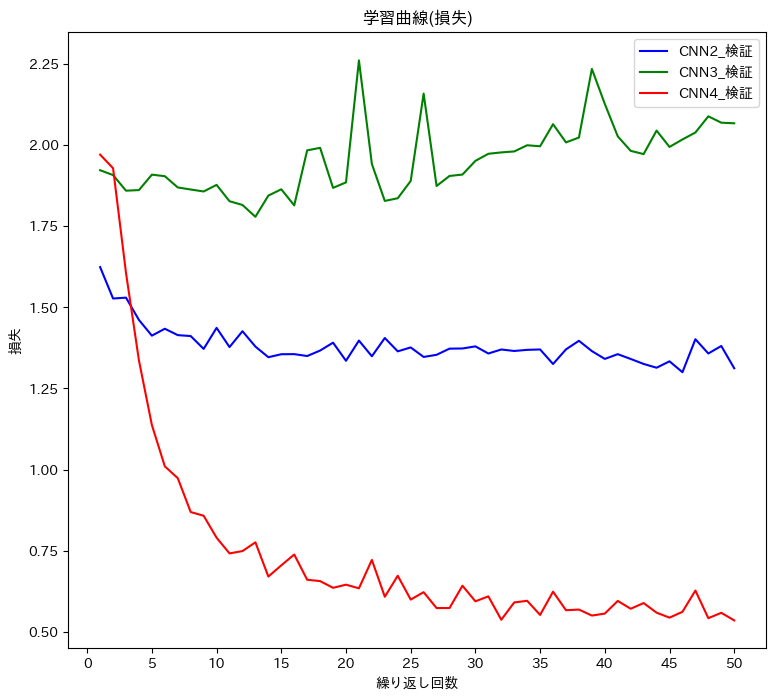

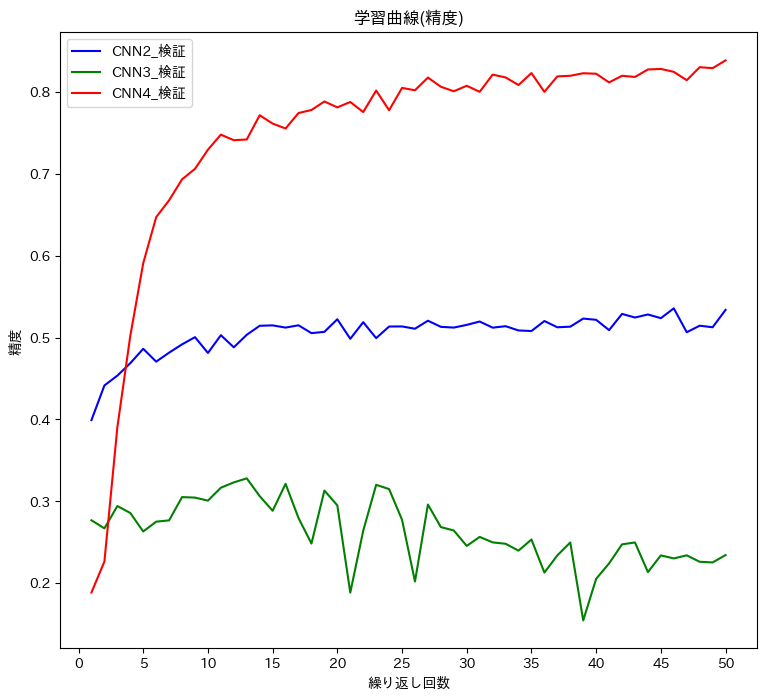

In [15]:
import matplotlib.pyplot as plt
import japanize_matplotlib

print("CNN2の状態")
print(f'初期状態: 損失: {history1[0,3]:.5f} 精度: {history1[0,4]:.5f}')
print(f'最終状態: 損失: {history1[-1,3]:.5f} 精度: {history1[-1,4]:.5f}' )

print("CNN3の状態")
print(f'初期状態: 損失: {history2[0,3]:.5f} 精度: {history2[0,4]:.5f}')
print(f'最終状態: 損失: {history2[-1,3]:.5f} 精度: {history2[-1,4]:.5f}' )

print("CNN4の状態")
print(f'初期状態: 損失: {history3[0,3]:.5f} 精度: {history3[0,4]:.5f}')
print(f'最終状態: 損失: {history3[-1,3]:.5f} 精度: {history3[-1,4]:.5f}' )

plt.figure(figsize=(9,8))
num_epochs1 = len(history1)
unit1 = num_epochs1 / 10
num_epochs2 = len(history2)
unit2 = num_epochs2 / 10
num_epochs3 = len(history3)
unit3 = num_epochs3 / 10
plt.plot(history1[:,0], history1[:,3], 'b', label='CNN2_検証')
plt.xticks(np.arange(0,num_epochs1+1, unit1))
plt.plot(history2[:,0], history2[:,3], 'g', label='CNN3_検証')
plt.xticks(np.arange(0,num_epochs2+1, unit2))
plt.plot(history3[:,0], history3[:,3], 'r', label='CNN4_検証')
plt.xticks(np.arange(0,num_epochs3+1, unit3))
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(損失)')
plt.legend()
plt.show()

plt.figure(figsize=(9,8))
plt.plot(history1[:,0], history1[:,4], 'b', label='CNN2_検証')
plt.xticks(np.arange(0,num_epochs1+1, unit1))
plt.plot(history2[:,0], history2[:,4], 'g', label='CNN3_検証')
plt.xticks(np.arange(0,num_epochs2+1, unit2))
plt.plot(history3[:,0], history3[:,4], 'r', label='CNN4_検証')
plt.xticks(np.arange(0,num_epochs3+1, unit3))
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.legend()
plt.show()